In [1]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\aniru\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
import optionTest as o
#Define functions to make text boxes on figure 

def makeBBoxes(ax, df):
    #Average VRP
    avg_vrp = df.loc[:, 'VRP'].mean()
    if avg_vrp > 0:
        color = "#90EE90"
    else:
        color = "#FF474C"

    props = dict(boxstyle='round', facecolor=color, alpha=1)  # bbox features
    ax.text(1.03, 0.88, 'Average VRP: ' + str(round(avg_vrp, 2)), transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

    #Moving Average VRP
    moving_avg = o.calc_movingAvg(df)
    if moving_avg > 0:
        color = "#90EE90"
    else:
        color = "#FF474C"

    props = dict(boxstyle='round', facecolor=color, alpha=1)  # bbox features
    ax.text(1.03, 0.68, 'Moving Average VRP: ' + str(round(moving_avg, 2)), transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

    #VRP Win Rate
    win_rate = o.calc_VRPWinRate(df)
    if win_rate > 50:
        color = "#90EE90"
    else:
        color = "#FF474C"

    props = dict(boxstyle='round', facecolor=color, alpha=1)  # bbox features
    ax.text(1.03, 0.48, 'VRP Win Rate: ' + str(round(win_rate, 1)) + '%', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

    #IV Percentile
    ivPercentile = o.calc_ivPercentile(df)
    if ivPercentile < 80:
        color = "#90EE90"
    else:
        color = "#FF474C"

    props = dict(boxstyle='round', facecolor=color, alpha=1)  # bbox features
    ax.text(1.03, 0.28, 'IV Percentile: ' + str(int(round(ivPercentile))), transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

In [ ]:
#Get a list of tickers sorted by their 10 day moving VRP Average 
import optionTest as o
import matplotlib.pyplot as plt
import math
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

#Connect to dolt database to grab implied volatilities
cnx = o.create_connection()

tickerList = o.getTickerList(cnx)
tickerList = sorted(tickerList)

tickerDict = o.orderTickersByMovingAverage(tickerList, cnx)
sortedTickers = sorted(tickerDict.items(), key=lambda item: -999999 if math.isnan(item[1]) else item[1], reverse=True) #(NaN breaks sorted so replace NaN with -999999)

o.close_connection(cnx)

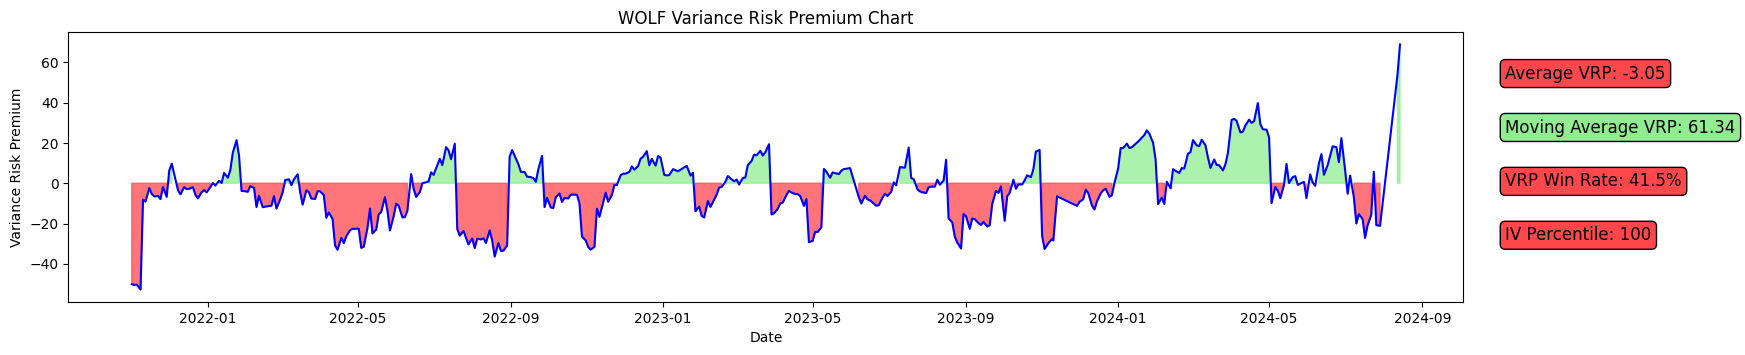

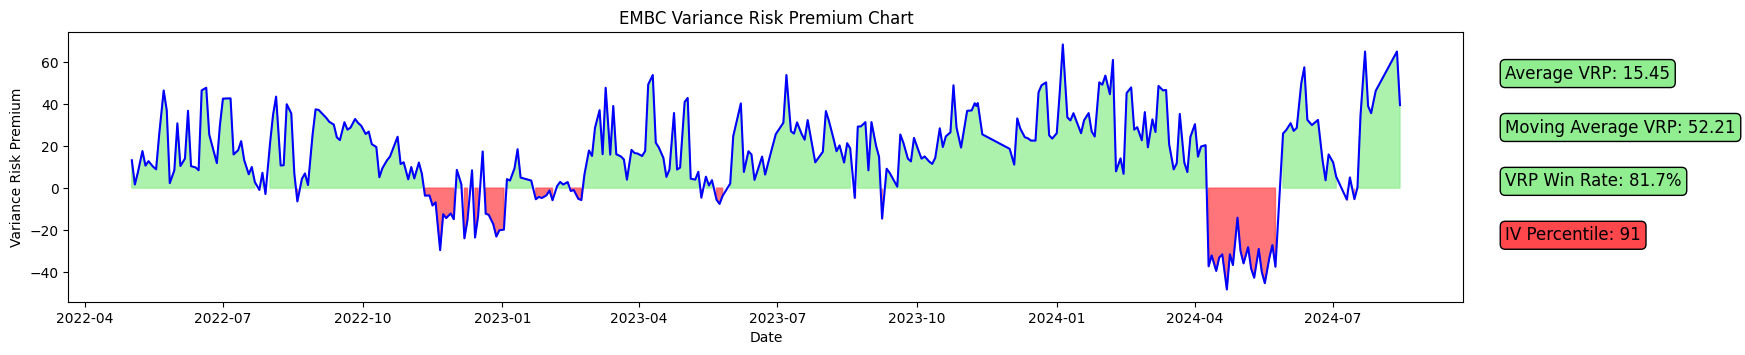

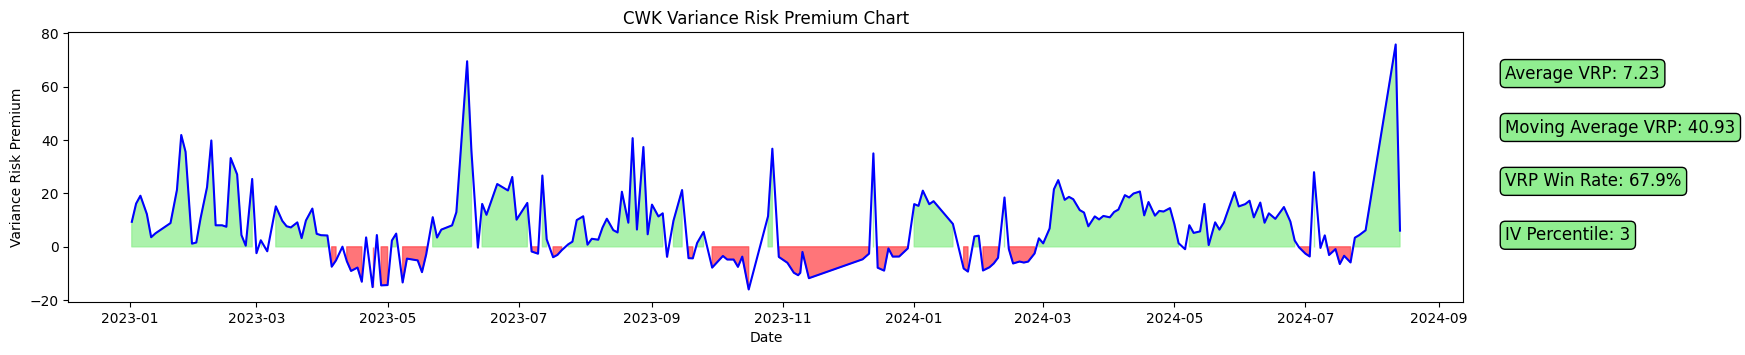

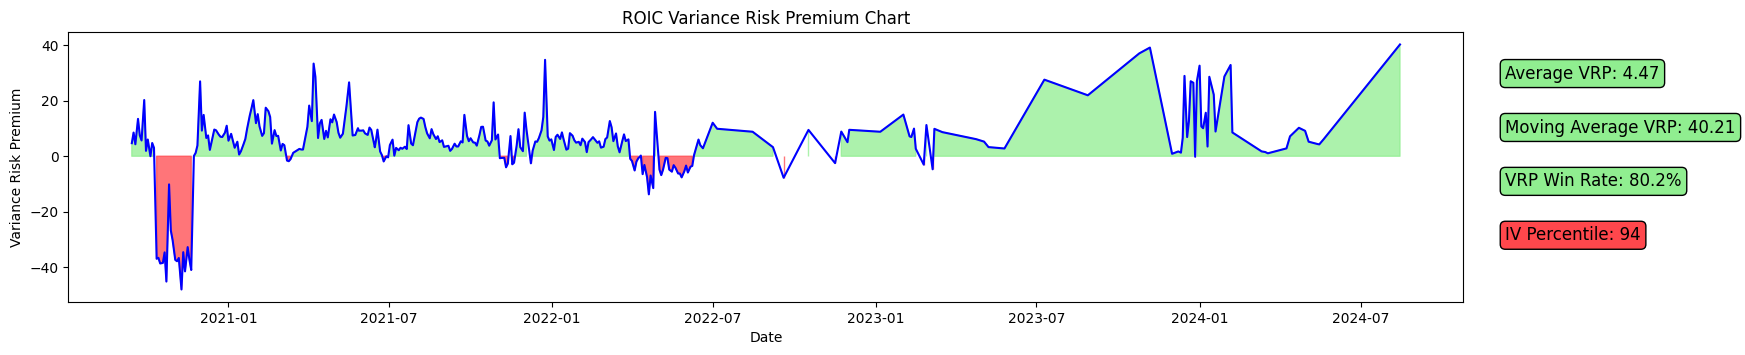

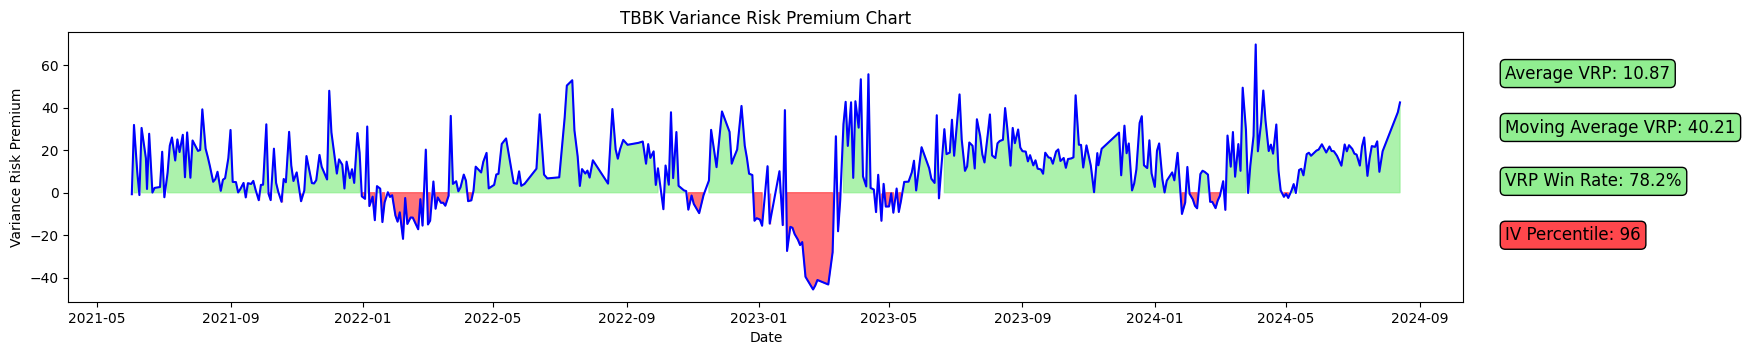

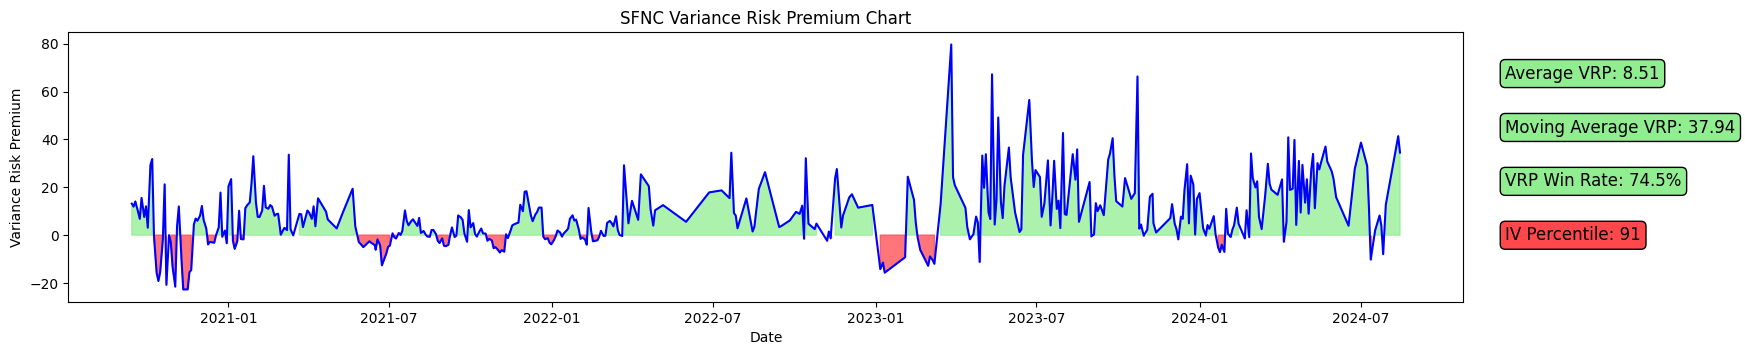

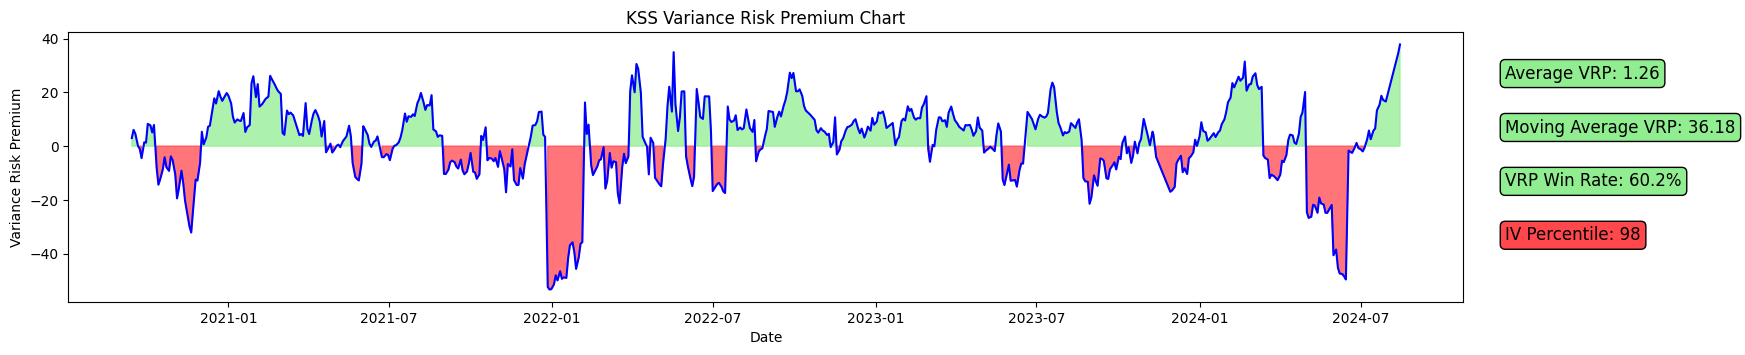

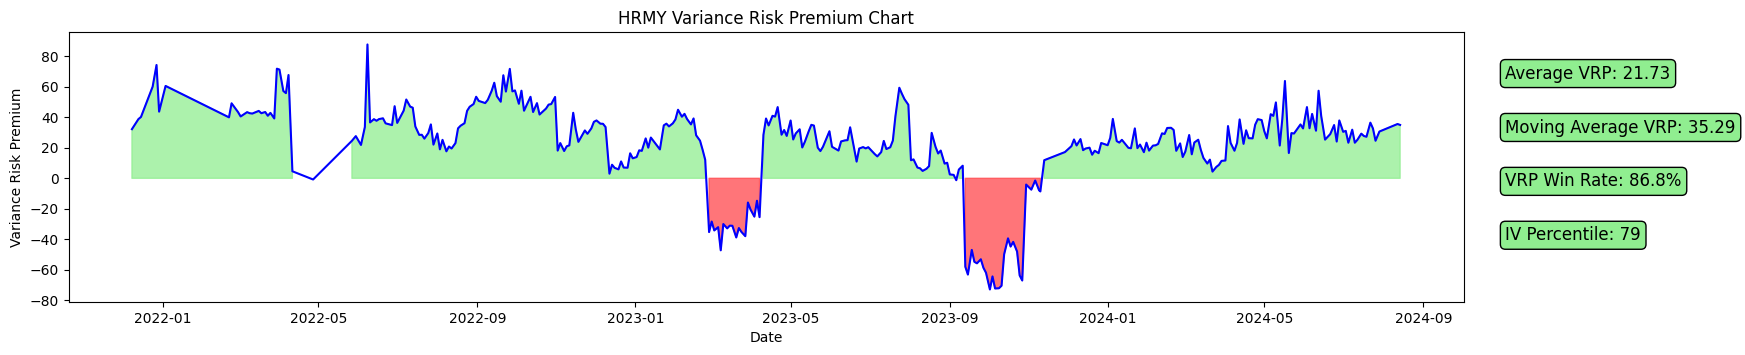

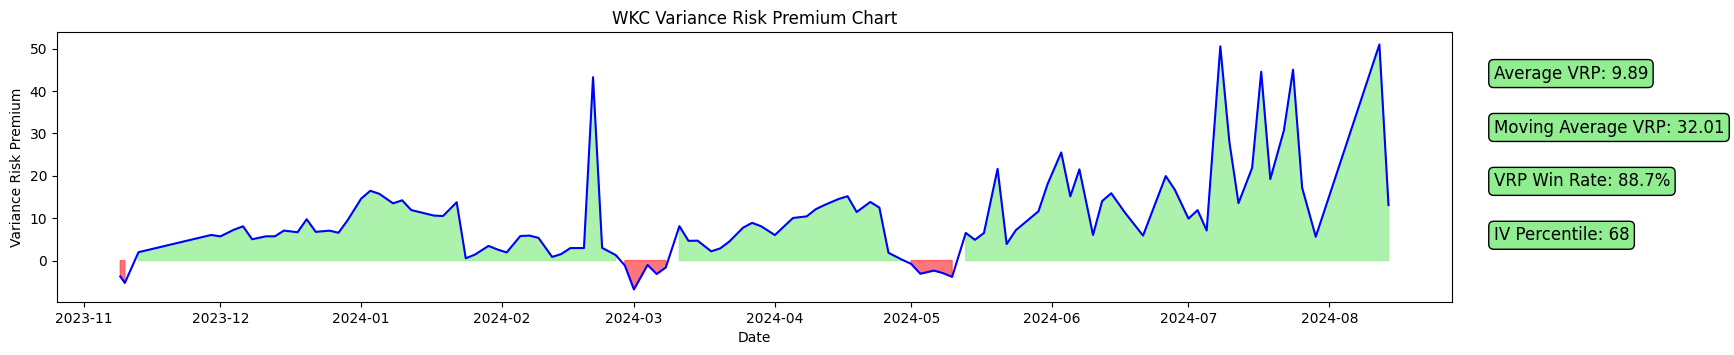

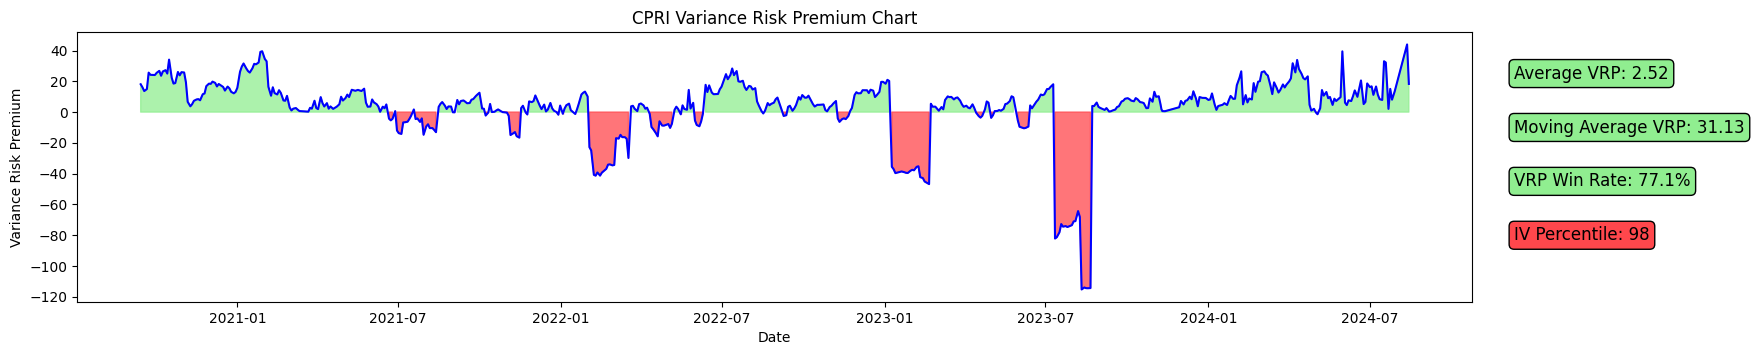

In [23]:
import optionTest as o
import matplotlib.pyplot as plt
import math
import warnings

#Pick the top 10 tickers to explore in greater detail
tickers = sortedTickers[0:10]

warnings.filterwarnings('ignore')


#Connect to dolt database to grab implied volatilities
cnx = o.create_connection()
for ticker in tickers:
    ticker = ticker[0]
    query = "SELECT date, iv_current FROM volatility_history WHERE act_symbol = '" + ticker + "' order by date desc;"

    implied = o.get_iv(cnx, query)


    #Get realized volatilities and create a dataframe that joins implied and realized and calculates Variance Risk Premium
    realized = o.get_rv(ticker, "5y")
    realized = o.fill_empty_volatilities(realized)
    combined = o.link_volatilies(implied, realized)
    combined = o.calc_VRP(combined)

    #Save dataframe to excel (useful for testing and further analysis)
    combined.to_excel(str(ticker) + '.xlsx')

    #initialize figure
    plt.rcParams["figure.figsize"] = [18.00, 3.50]

    X = combined["date"]
    Y = combined["VRP"]
    fig, ax = plt.subplots()

    ax.plot(X, Y, color='blue', alpha=1.00)
    ax.set_title(str(ticker) + " Variance Risk Premium Chart")
    ax.set_xlabel('Date')
    ax.set_ylabel('Variance Risk Premium')

    #Make area under graph green when VRP is positive and red when VRP is negative
    ax.fill_between(X, Y, 0, color='#FF474C', where=Y < 0, alpha=0.75)
    ax.fill_between(X, Y, 0, color='#90EE90', where=Y > 0, alpha=0.75)

    #Add text boxes to display key insights
    makeBBoxes(ax, combined)
        
plt.show()

o.close_connection(cnx)
